In [ ]:
librarian::shelf(tidyverse, tidymodels, kableExtra, patchwork, 
                skimr, gridExtra, janitor, corrplot, scales,
                GGally, car, forcats, performance, glmmTMB, 
                splines, mgcv, DHARMa, zoo, ggpubr, ggridges,
                caret, rstatix, Metrics)

In [2]:
df <- read_csv("data/weatherAUS.csv")

Rows: 145460 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): Location, WindGustDir, WindDir9am, WindDir3pm, RainToday, RainTom...
dbl  (16): MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed,...
date  (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
df %>% 
  head() %>% 
  kable()
  # kable(format = "html") %>%
  # kable_styling(bootstrap_options = c("striped", "hover", "condensed"))

In [4]:
df %>% 
  tail() %>% 
  kable()
  # kable(format = "html") %>%
  # kable_styling(bootstrap_options = c("striped", "hover", "condensed"))

In [5]:
df_clean <- df %>%
  clean_names() %>%
  mutate(
    date = as.Date(date),
    month = as.factor(month(date)),
    day = as.factor(wday(date, label = TRUE))
  ) %>%
  filter(!is.na(rainfall))

In [6]:
df_clean %>% 
  names()

 [1] "date"            "location"        "min_temp"        "max_temp"       
 [5] "rainfall"        "evaporation"     "sunshine"        "wind_gust_dir"  
 [9] "wind_gust_speed" "wind_dir9am"     "wind_dir3pm"     "wind_speed9am"  
[13] "wind_speed3pm"   "humidity9am"     "humidity3pm"     "pressure9am"    
[17] "pressure3pm"     "cloud9am"        "cloud3pm"        "temp9am"        
[21] "temp3pm"         "rain_today"      "rain_tomorrow"   "month"          
[25] "day"            

In [7]:
# Check for duplicates

duplicates <- df_clean %>% 
  get_dupes()

print(paste("Number of duplicate rows: ", nrow(duplicates)))

No variable names specified - using all columns.

No duplicate combinations found of: date, location, min_temp, max_temp, rainfall, evaporation, sunshine, wind_gust_dir, wind_gust_speed, ... and 16 other variables
[1] "Number of duplicate rows:  0"


In [8]:
df_clean

# A tibble: 142,199 × 25
   date       location min_temp max_temp rainfall evaporation sunshine
   <date>     <chr>       <dbl>    <dbl>    <dbl>       <dbl>    <dbl>
 1 2008-12-01 Albury       13.4     22.9      0.6          NA       NA
 2 2008-12-02 Albury        7.4     25.1      0            NA       NA
 3 2008-12-03 Albury       12.9     25.7      0            NA       NA
 4 2008-12-04 Albury        9.2     28        0            NA       NA
 5 2008-12-05 Albury       17.5     32.3      1            NA       NA
 6 2008-12-06 Albury       14.6     29.7      0.2          NA       NA
 7 2008-12-07 Albury       14.3     25        0            NA       NA
 8 2008-12-08 Albury        7.7     26.7      0            NA       NA
 9 2008-12-09 Albury        9.7     31.9      0            NA       NA
10 2008-12-10 Albury       13.1     30.1      1.4          NA       NA
# ℹ 142,189 more rows
# ℹ 18 more variables: wind_gust_dir <chr>, wind_gust_speed <dbl>,
#   wind_dir9am <chr>, wind_dir3pm

In [9]:
# Day Distribution

day_tab <- df_clean %>% 
  filter(rainfall > 0) %>% 
  tabyl(day) %>% 
  adorn_pct_formatting() %>% 
  arrange(desc(n))

print(day_tab)

 day    n percent
 Tue 7508   14.7%
 Mon 7480   14.6%
 Fri 7378   14.4%
 Wed 7342   14.4%
 Thu 7314   14.3%
 Sat 7057   13.8%
 Sun 7040   13.8%


In [10]:
# Month distribution

month_tab <- df_clean %>% 
  filter(rainfall > 0) %>% 
  tabyl(month) %>% 
  adorn_pct_formatting() %>% 
  arrange(desc(n))

print(month_tab)

 month    n percent
     6 5448   10.7%
     7 5250   10.3%
     5 4937    9.7%
     8 4704    9.2%
     3 4444    8.7%
     9 4234    8.3%
     4 4001    7.8%
    10 3770    7.4%
    11 3760    7.4%
     1 3702    7.2%
    12 3562    7.0%
     2 3307    6.5%


In [11]:
cat("\nCross-tabulation: Month vs Day:\n")
cross_tab <- df_clean %>% 
  filter(rainfall > 0) %>% 
  tabyl(month, day) %>% 
  adorn_totals(c("row", "col"))
print(cross_tab)


Cross-tabulation: Month vs Day:
 month  Sun  Mon  Tue  Wed  Thu  Fri  Sat Total
     1  536  570  514  482  493  567  540  3702
     2  480  530  469  466  443  471  448  3307
     3  636  645  639  592  662  644  626  4444
     4  578  597  566  604  579  515  562  4001
     5  710  722  765  714  678  681  667  4937
     6  766  801  804  797  760  753  767  5448
     7  694  717  728  796  773  818  724  5250
     8  612  702  694  679  689  687  641  4704
     9  516  571  616  639  648  659  585  4234
    10  507  606  579  550  517  456  555  3770
    11  556  526  554  480  538  575  531  3760
    12  449  493  580  543  534  552  411  3562
 Total 7040 7480 7508 7342 7314 7378 7057 51119


In [12]:
print(paste("Total Missing values: ", sum(is.na(df))))

[1] "Total Missing values:  343248"


In [13]:
missing_tab <- df_clean %>%
  summarise(across(everything(), ~ mean(is.na(.)) * 100)) %>%
  pivot_longer(everything(), names_to = "column", values_to = "pct_missing") %>%
  arrange(desc(pct_missing))

missing_tab %>% 
  kable()



|column          | pct_missing|
|:---------------|-----------:|
|sunshine        |  47.6937250|
|evaporation     |  42.5375706|
|cloud3pm        |  39.9960619|
|cloud9am        |  37.5044832|
|pressure3pm     |   9.8404349|
|pressure9am     |   9.8031632|
|wind_dir9am     |   6.8840147|
|wind_gust_dir   |   6.8390073|
|wind_gust_speed |   6.7968129|
|wind_dir3pm     |   2.6716081|
|humidity3pm     |   2.5527606|
|temp3pm         |   1.9310966|
|wind_speed3pm   |   1.8614758|
|humidity9am     |   1.0928347|
|rain_tomorrow   |   0.9929746|
|wind_speed9am   |   0.7672347|
|temp9am         |   0.4817193|
|min_temp        |   0.3424778|
|max_temp        |   0.3305227|
|date            |   0.0000000|
|location        |   0.0000000|
|rainfall        |   0.0000000|
|rain_today      |   0.0000000|
|month           |   0.0000000|
|day             |   0.0000000|

In [14]:
# Obtain the summary statistics for the target variable

rainfall_stats <- df_clean %>% 
  summarise(
    n = n(),
    mean = mean(rainfall),
    median = median(rainfall),
    sd = sd(rainfall),
    min = min(rainfall),
    max = max(rainfall),
    q25 = quantile(rainfall, 0.25),
    q75 = quantile(rainfall, .75),
    iqr = IQR(rainfall),
    n_zeros = sum(rainfall == 0),
    pct_zeros = mean(rainfall == 0) * 100,
    n_large = sum(rainfall > 100),
    pct_large = mean(rainfall > 100) * 100,
    skewness = moments::skewness(rainfall),
    kurtosis = moments::kurtosis(rainfall)
  )

t(rainfall_stats) %>% 
  kable()



|          |             |
|:---------|------------:|
|n         | 1.421990e+05|
|mean      | 2.360918e+00|
|median    | 0.000000e+00|
|sd        | 8.478060e+00|
|min       | 0.000000e+00|
|max       | 3.710000e+02|
|q25       | 0.000000e+00|
|q75       | 8.000000e-01|
|iqr       | 8.000000e-01|
|n_zeros   | 9.108000e+04|
|pct_zeros | 6.405108e+01|
|n_large   | 1.510000e+02|
|pct_large | 1.061892e-01|
|skewness  | 9.836122e+00|
|kurtosis  | 1.811458e+02|

In [15]:

rain_check <- df_clean %>%
  summarise(
    total_days = n(),
    dry_days = sum(rainfall == 0),
    rainy_days = sum(rainfall > 0),
    zero_inflation_pct = (dry_days / total_days) * 100
  )

rain_check %>% 
  kable()



| total_days| dry_days| rainy_days| zero_inflation_pct|
|----------:|--------:|----------:|------------------:|
|     142199|    91080|      51119|           64.05108|

In [16]:
numeric_cols <- df_clean %>% 
select(where(is.numeric)) %>% 
names()

numeric_cols <- numeric_cols[numeric_cols != "rainfall"]


cors <- df_clean%>%
rstatix::cor_test(vars = "rainfall", vars2 = numeric_cols, method = "spearman") %>%
filter(!is.na(cor)) %>%
arrange(desc(abs(cor))) %>%
dplyr::select(var2, cor, p) %>%
mutate(interpretation = case_when(
  abs(cor) < 0.1 ~ "Negligible",
  abs(cor) < 0.3 ~ "Small",
  abs(cor) < 0.5 ~ "Moderate",
  TRUE ~ "Large"
))

cors

Warning message:
Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(numeric_cols)

  # Now:
  data %>% select(all_of(numeric_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This warning is displayed once per session.
Call ]8;;x-r-run:lifecycle::last_lifecycle_warnings()lifecycle::last_lifecycle_warnings()]8;; to see where this warning was
generated. 


# A tibble: 15 × 4
   var2               cor         p interpretation
   <chr>            <dbl>     <dbl> <chr>         
 1 humidity9am      0.44  0         Moderate      
 2 humidity3pm      0.44  0         Moderate      
 3 sunshine        -0.4   0         Moderate      
 4 cloud9am         0.37  0         Moderate      
 5 cloud3pm         0.32  0         Moderate      
 6 evaporation     -0.31  0         Moderate      
 7 temp3pm         -0.31  0         Moderate      
 8 max_temp        -0.3   0         Moderate      
 9 pressure9am     -0.15  0         Small         
10 temp9am         -0.15  0         Small         
11 wind_gust_speed  0.13  0         Small         
12 wind_speed9am    0.083 1.02e-212 Negligible    
13 wind_speed3pm    0.068 5.65e-143 Negligible    
14 pressure3pm     -0.063 1.64e-114 Negligible    
15 min_temp         0.022 3.04e- 17 Negligible    

In [17]:
print(paste("Total Missing values: ", sum(is.na(df_clean))))

[1] "Total Missing values:  314146"


In [18]:
missing_val <- function(df){
  missing_tab <- df %>% 
    summarise(across(everything(), ~mean(is.na(.)) * 100)) %>% 
    pivot_longer(everything(), names_to = "column", values_to = "pct_missing") %>% 
    arrange(desc(pct_missing))

  return(missing_tab %>% kable())
}


missing_val(df_clean)



|column          | pct_missing|
|:---------------|-----------:|
|sunshine        |  47.6937250|
|evaporation     |  42.5375706|
|cloud3pm        |  39.9960619|
|cloud9am        |  37.5044832|
|pressure3pm     |   9.8404349|
|pressure9am     |   9.8031632|
|wind_dir9am     |   6.8840147|
|wind_gust_dir   |   6.8390073|
|wind_gust_speed |   6.7968129|
|wind_dir3pm     |   2.6716081|
|humidity3pm     |   2.5527606|
|temp3pm         |   1.9310966|
|wind_speed3pm   |   1.8614758|
|humidity9am     |   1.0928347|
|rain_tomorrow   |   0.9929746|
|wind_speed9am   |   0.7672347|
|temp9am         |   0.4817193|
|min_temp        |   0.3424778|
|max_temp        |   0.3305227|
|date            |   0.0000000|
|location        |   0.0000000|
|rainfall        |   0.0000000|
|rain_today      |   0.0000000|
|month           |   0.0000000|
|day             |   0.0000000|

In [19]:
clean_and_impute_weather <- function(df){
  # For the columns with the highest missing data interpolation will fail
  # Logic: Since interpolation fails, we will use the typical value fo this month and location

  fill_hierarchical <- function(x, loc, mth){
    # If value exists, keep it
    # If missing try location-month median
    # if thats missing (loc has no data), try globa-month median,
    # Else just fallback to global median

    df_temp <- data.frame(val = x, loc = loc, mth = mth)

    df_temp <- df_temp %>% 
      group_by(loc, mth) %>% 
      mutate(med_loc_mth = median(val, na.rm = TRUE)) %>% 
      ungroup() %>% 
      group_by(mth) %>% 
      mutate(med_mth = median(val, na.rm = TRUE)) %>% 
      ungroup()

    # Take the first non NA value
    coalesce(df_temp$val, df_temp$med_loc_mth, df_temp$med_mth, median(x, na.rm=TRUE))
    
  }
  # Heper function to calculate mode
  calc_mode <- function(x) {
  ux <- unique(na.omit(x))
  if(length(ux) == 0) return(NA)
  ux[which.max(tabulate(match(x, ux)))]
  }

  interp_vars <- c("min_temp", "max_temp", "temp9am", "temp3pm",
                   "humidity9am", "humidity3pm", "pressure9am", "pressure3pm",
                   "wind_speed9am", "wind_speed3pm", "wind_gust_speed")
  
  df_processed <- df %>% 
    arrange(location, date) %>% 
    mutate(
      sunshine_imp_flagged = ifelse(is.na(sunshine), 1, 0),
      evap_imp_flagged = ifelse(is.na(evaporation), 1, 0),
      cloud3pm_imp_flagged = ifelse(is.na(cloud3pm), 1, 0),
      cloud9am_imp_flagged = ifelse(is.na(cloud9am), 1, 0),
    ) %>% 
    group_by(location) %>% 
    # The idea is that we do not gues if we are having more than 3 days missing,
    #  while keeping the leading/trailing NAs s they dont crash on empty groups
    mutate(across(all_of(interp_vars),
                ~na.approx(., maxgap = 3, na.rm = FALSE, rule = 2))) %>% 
    ungroup() %>% 
    # Hierarchical filling for high-missing variables
    mutate(
      sunshine = fill_hierarchical(sunshine, location, month),
      evaporation = fill_hierarchical(evaporation, location, month),
      cloud3pm = fill_hierarchical(cloud3pm, location, month),
      cloud9am = fill_hierarchical(cloud9am, location, month)
    ) %>%
    # LOCF imputation
    group_by(location) %>%
    fill(c(wind_dir9am, wind_dir3pm, wind_gust_dir), .direction = "downup") %>%
    ungroup() %>%
    # Final cleanup: location+month medians/modes for any remaining NAs
    group_by(location, month) %>%
    mutate(
      across(c(pressure9am, pressure3pm, wind_gust_speed,
               humidity9am, humidity3pm, temp9am, temp3pm,
               min_temp, max_temp, wind_speed9am, wind_speed3pm),
             ~coalesce(., median(., na.rm = TRUE))),
      
      wind_gust_dir = coalesce(wind_gust_dir, calc_mode(wind_gust_dir))
    ) %>%
    ungroup() %>%
    
    # Global fallback for any remaining NAs
    mutate(
      across(c(pressure9am, pressure3pm, wind_gust_speed,
               humidity9am, humidity3pm, temp9am, temp3pm,
               min_temp, max_temp, wind_speed9am, wind_speed3pm),
             ~coalesce(., median(., na.rm = TRUE))),
      
      wind_gust_dir = coalesce(wind_gust_dir, calc_mode(wind_gust_dir))
    ) %>%
    
    # Filter out the rain_tomorrow column to prevent data leakage
    select(-rain_tomorrow)
  
  return(df_processed)
}

df_final <- clean_and_impute_weather(df_clean)

In [20]:
missing_val(df_final)



|column               | pct_missing|
|:--------------------|-----------:|
|date                 |           0|
|location             |           0|
|min_temp             |           0|
|max_temp             |           0|
|rainfall             |           0|
|evaporation          |           0|
|sunshine             |           0|
|wind_gust_dir        |           0|
|wind_gust_speed      |           0|
|wind_dir9am          |           0|
|wind_dir3pm          |           0|
|wind_speed9am        |           0|
|wind_speed3pm        |           0|
|humidity9am          |           0|
|humidity3pm          |           0|
|pressure9am          |           0|
|pressure3pm          |           0|
|cloud9am             |           0|
|cloud3pm             |           0|
|temp9am              |           0|
|temp3pm              |           0|
|rain_today           |           0|
|month                |           0|
|day                  |           0|
|sunshine_imp_flagged |           0|

# EDA

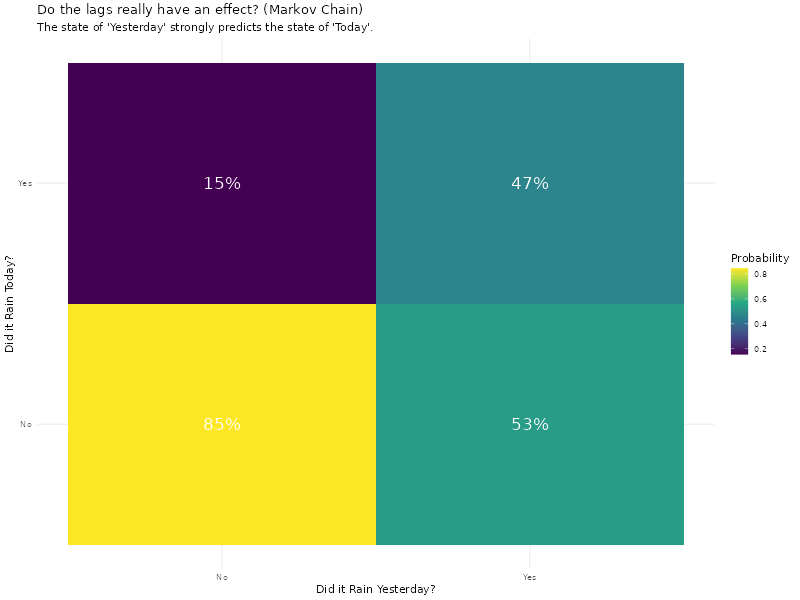

In [21]:
# Does it matter to know if it rained yesterday to predict if it will rain today?
df_final %>%
  group_by(location) %>%
  arrange(date) %>%
  mutate(yesterday_rain = lag(rain_today)) %>%
  ungroup() %>%
  
  # Remove NA introduced by lags
  filter(!is.na(rain_today), !is.na(yesterday_rain)) %>%
  count(yesterday_rain, rain_today) %>%
  group_by(yesterday_rain) %>%
  mutate(prob = n / sum(n)) %>%

  ggplot(aes(x = yesterday_rain, y = rain_today, fill = prob)) +
  geom_tile() +
  geom_text(aes(label = scales::percent(prob, accuracy = 1)), color = "white", size = 6) +
  scale_fill_viridis_c() +
  labs(
    title = "Do the lags really have an effect? (Markov Chain)",
    subtitle = "The state of 'Yesterday' strongly predicts the state of 'Today'.",
    x = "Did it Rain Yesterday?",
    y = "Did it Rain Today?",
    fill = "Probability"
  ) +
  theme_minimal()

Well it does, if it rained yesterday, then there is an 85% chance it wont rain today, if it rained yesterday its almost a coin toss it will rain today but the probability of raining triples if it did rain yesterday.

Warning message:
In geom_density2d_filled(continuous_var = "ndensity", bins = 7) :
  Ignoring unknown parameters: `continuous_var`


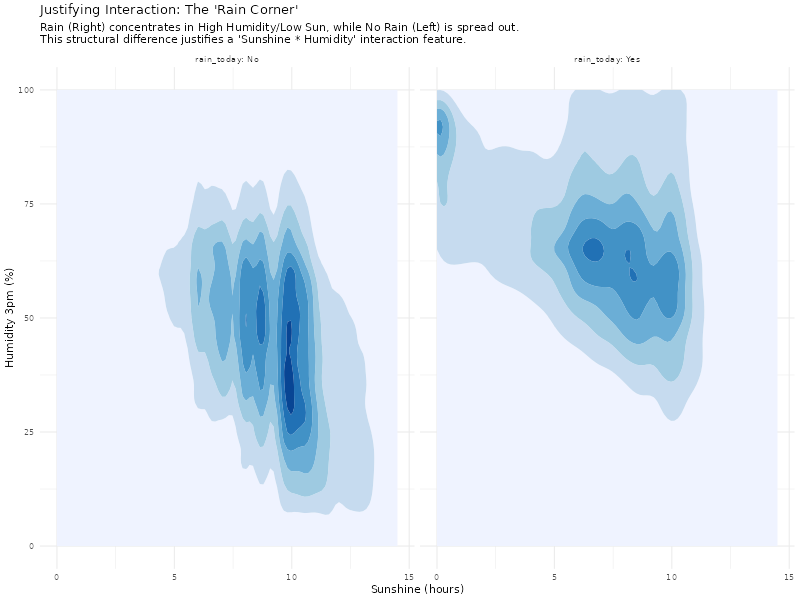

In [22]:
df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    rain_index_ref = ifelse(rainfall > 0, row_number(), NA_integer_)
  ) %>% 
  fill(rain_index_ref, .direction = "down") %>% 
  mutate(
    days_since_rain = row_number() - lag(rain_index_ref)
  ) %>% 
  select(-rain_index_ref) %>% 
  ggplot(aes(sunshine, humidity3pm)) +
  geom_density2d_filled(continuous_var = "ndensity", bins = 7) +
  facet_wrap(~rain_today, labeller = label_both) +
  scale_fill_brewer(palette = "Blues") +
  labs(
    title = "Justifying Interaction: The 'Rain Corner'",
    subtitle = "Rain (Right) concentrates in High Humidity/Low Sun, while No Rain (Left) is spread out.\nThis structural difference justifies a 'Sunshine * Humidity' interaction feature.",
    x = "Sunshine (hours)",
    y = "Humidity 3pm (%)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

There exists a non linear, conditional relationship with rainfall. the no rain class shows a broad distribution, indicating a high humidity alone doesnt guarantee precipitation if enough sunshine is present. The rain class is confined to a specific corner of the feature space, the intersecion of low sunshine and high humidity

This then demonstrates that the effect on rainfall probability is conditional on the level of sunshine, so we should add an interaction term between the two

Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once per session.
Call ]8;;x-r-run:lifecycle::last_lifecycle_warnings()lifecycle::last_lifecycle_warnings()]8;; to see where this warning was
generated. 


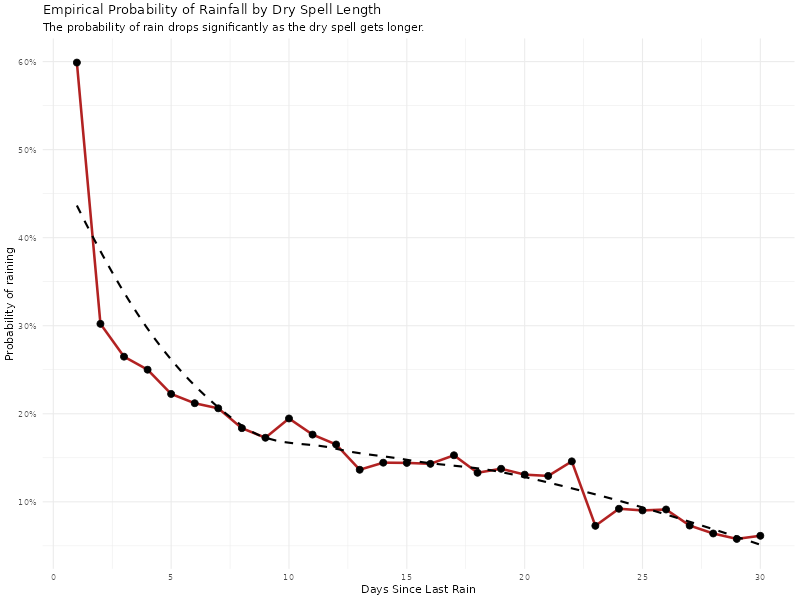

`geom_smooth()` using formula = 'y ~ x'

In [23]:
df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    did_rain_yesterday = lag(rainfall > 0, default = FALSE) ,
    dry_spell_id = cumsum(did_rain_yesterday)
  ) %>% 
  group_by(location, dry_spell_id) %>% 
  # Count days weve been in this dry spell
  mutate(days_since_rain = row_number()) %>% 
  ungroup() %>% 
  filter(days_since_rain <= 30) %>%
  group_by(days_since_rain) %>%
  summarise(prob_rain = mean(rainfall > 0, na.rm = TRUE)) %>%
  ggplot(aes(x = days_since_rain, y = prob_rain)) +
  geom_line(color = "firebrick", size = 1.2) +
  geom_point(size = 3) +
  geom_smooth(method = "loess", se = FALSE, color = "black", linetype = "dashed") +
  scale_y_continuous(labels = scales::percent_format(1),
                    breaks = pretty_breaks(n = 6)) +
  scale_x_continuous(breaks = scales::pretty_breaks()) +
  labs(x = "Days Since Last Rain", 
       y = "Probability of raining", 
       subtitle = "The probability of rain drops significantly as the dry spell gets longer.",
       title = "Empirical Probability of Rainfall by Dry Spell Length") +
  theme_minimal()

The probability of rainfall exhibits strong state dependence based on the duration of the preceding dry spell. the empirical probability f precipitation follows a non linear decay function relative to the nummber of days since the last rainfall event. The probability of rain at day 1 is 60%, it drops sharply to 10 percent at day 25, this is an indication that rainfall occurrence are not Poisson events. we need to make days_since_rain feature to mode the thermodynamic barrier, where longer dry spells impose statisticaly higher thresholds for generating new precipitation.

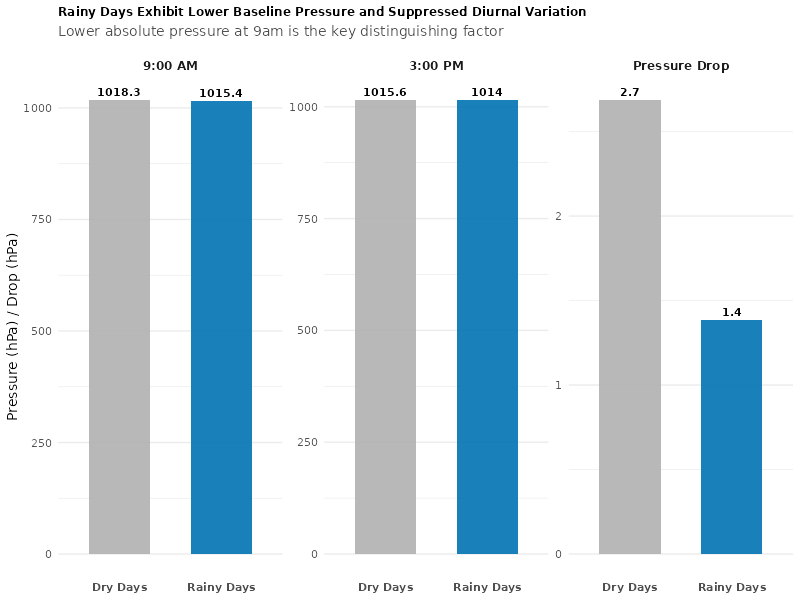

In [24]:
# Analyze the pressure change
data_wide <- df_final %>% 
  group_by(rain_today) %>% 
  summarise(
    `9:00 AM` = mean(pressure9am, na.rm = TRUE),
    `3:00 PM` = mean(pressure3pm, na.rm = TRUE),
    `Pressure Drop` = mean(pressure9am, na.rm = TRUE) - mean(pressure3pm, na.rm = TRUE)
  ) %>% 
  pivot_longer(cols = -rain_today, names_to = "metric", values_to = "value") %>% 
  mutate(
    metric = factor(metric, levels = c("9:00 AM", "3:00 PM", "Pressure Drop")),
    label_txt = round(value, 1)
  )

ggplot(data_wide, aes(x = rain_today, y = value, fill = rain_today)) +
  geom_col(width = 0.6, alpha = 0.9) +
  geom_text(aes(label = label_txt), vjust = -0.5, fontface = "bold", size = 4) +
  facet_wrap(~metric, scales = "free_y", nrow = 1) +
  
  scale_fill_manual(values = c("No" = "#B0B0B0", "Yes" = "#0072B2")) +
  scale_x_discrete(labels = c("No" = "Dry Days", "Yes" = "Rainy Days")) +
  
  labs(
    title = "Rainy Days Exhibit Lower Baseline Pressure and Suppressed Diurnal Variation",
    subtitle = "Lower absolute pressure at 9am is the key distinguishing factor",
    y = "Pressure (hPa) / Drop (hPa)",
    x = NULL
  ) +
  
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "none",
    plot.title = element_text(face = "bold", size = 12),
    plot.subtitle = element_text(color = "grey30", margin = margin(b = 15)),
    axis.text.x = element_text(face = "bold", size = 11),
    strip.text = element_text(face = "bold", size = 12),
    panel.grid.major.x = element_blank()
  )


In [25]:
df_final %>% 
  mutate(pressure_change = pressure3pm - pressure9am) %>% 
  rstatix::cohens_d(pressure_change ~ rain_today)

# A tibble: 1 × 7
  .y.             group1 group2 effsize     n1    n2 magnitude
* <chr>           <chr>  <chr>    <dbl>  <int> <int> <ord>    
1 pressure_change No     Yes     -0.676 110319 31880 moderate 

We analyze the structural differences in diurnal pressure variation. dry days show a stronger diurnal tide driven by solar heating, whereas rainy days show a surpressed decline due to cloud insulation.
statistical analysis confirms the magnitude of this separation. despite the absolute difference being small (~1.3hPa), the standardized effect size is substantial (Cohen's d = -.68). This moderate effect confirms that the suppression of the diurnal drop is a robust physical signal for precipitation, distinct from the absolute pressure baseline.

In [26]:
df_final %>% 
  filter(rainfall > 0) %>% 
  group_by(month) %>% 
  summarise(median_rain = median(rainfall),
            mean_rain = mean(rainfall),
            rain_days = n(),
          .groups = "drop") %>% 
  mutate(month_label = factor(month.abb[month], levels = rev(month.abb))) -> monthly_stats

df_final %>% 
  filter(rainfall > 0) %>% 
  mutate(
    month_label = factor(month.abb[month], levels = rev(month.abb)),
    log_rain = log(rainfall)
  ) %>% 
  left_join(monthly_stats, by = c("month", "month_label")) -> plot_data



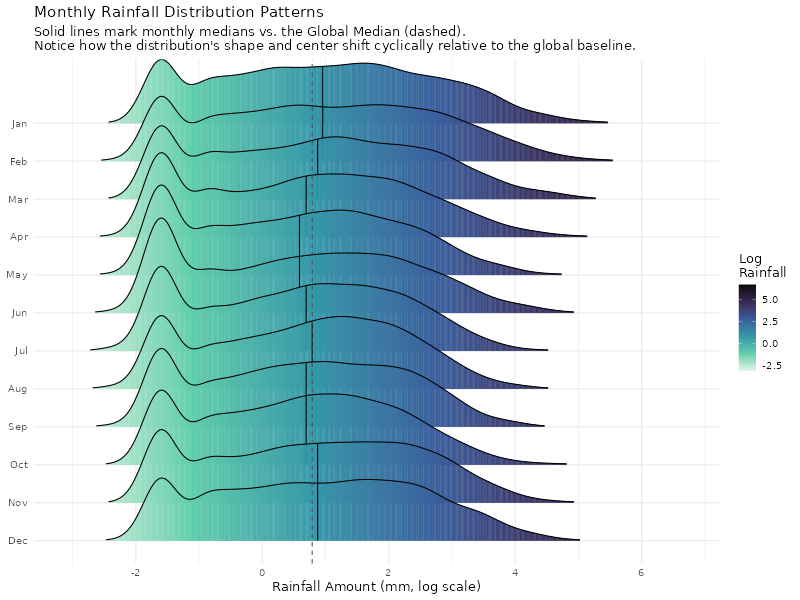

Picking joint bandwidth of 0.273

In [ ]:

ggplot(plot_data, aes(log_rain, month_label, fill = after_stat(x))) +
  geom_density_ridges_gradient(    
    scale = 2.5, 
    rel_min_height = 0.01,
    quantile_lines = TRUE,
    quantiles = 2,  # Show median line
    alpha = 0.8
  ) +
  # Add the global median
  geom_vline(xintercept = median(log(df_final$rainfall[df_final$rainfall > 0])),
             linetype = "dashed", color = "grey30", linewidth = 0.5) +
  scale_fill_viridis_c(
    option = "mako", 
    name = "Log\nRainfall",
    direction = -1
  ) +
  scale_x_continuous(breaks = pretty_breaks()) +
  labs(
    title = "Monthly Rainfall Distribution Patterns",
    subtitle = "Solid lines mark monthly medians vs. the Global Median (dashed).\nNotice how the distribution's shape and center shift cyclically relative to the global baseline.",
    x = "Rainfall Amount (mm, log scale)",
    y = NULL,
  ) +
  
  theme_minimal(base_size = 13)

From the ridhe plot, we can see that seasonality drives rainfall distributions, however feedint the raw month number to the statistical mdel wont be good because it implies a false distance, mathematically the distance between Dec and Jan is 11, but temporally, they are adjacent.

We then need to preserve this continuity to map the time onto a unit circle using sine and cosine transformations

In [28]:
# Check rainfall seasonality
df_final %>% 
  filter(rainfall > 0) %>% 
  mutate(
    season = case_when(
      month %in% c(12, 1, 2) ~ "Summer",
      month %in% c(3, 4, 5) ~ "Autumn",
      month %in% c(6, 7, 8) ~ "Winter",
      month %in% c(9, 10, 11) ~ "Spring"
    ),
    season = factor(season, levels = c("Summer", "Autumn", "Winter", "Spring")),
    month_label = factor(month.abb[month], levels = month.abb)
  ) -> plot_data_seasonal



In [ ]:

plot_data_seasonal %>% 
  select(season, rainfall) -> seasonal_data

seasonal_data %>% 
  group_by(season) %>% 
  get_summary_stats(rainfall, type = "mean_sd")


Attaching package: ‘rstatix’

The following object is masked from ‘package:janitor’:

    make_clean_names

The following objects are masked from ‘package:infer’:

    chisq_test, prop_test, t_test

The following object is masked from ‘package:dials’:

    get_n

The following object is masked from ‘package:stats’:

    filter



# A tibble: 4 × 5
  season variable     n  mean    sd
  <fct>  <fct>    <dbl> <dbl> <dbl>
1 Summer rainfall 10571  9.07 18.2 
2 Autumn rainfall 13382  6.67 13.5 
3 Winter rainfall 15402  5.46  9.81
4 Spring rainfall 11764  5.65 10.5 

In [30]:
seasonal_data %>% 
  group_by(season) %>% 
  identify_outliers(rainfall)

# A tibble: 5,091 × 4
   season rainfall is.outlier is.extreme
   <fct>     <dbl> <lgl>      <lgl>     
 1 Summer     23.6 TRUE       FALSE     
 2 Summer     66.2 TRUE       TRUE      
 3 Summer     29   TRUE       FALSE     
 4 Summer     75.2 TRUE       TRUE      
 5 Summer     61.2 TRUE       TRUE      
 6 Summer     29   TRUE       FALSE     
 7 Summer     36.4 TRUE       TRUE      
 8 Summer     40   TRUE       TRUE      
 9 Summer     24.2 TRUE       FALSE     
10 Summer     52.2 TRUE       TRUE      
# ℹ 5,081 more rows
# ℹ Use `print(n = ...)` to see more rows

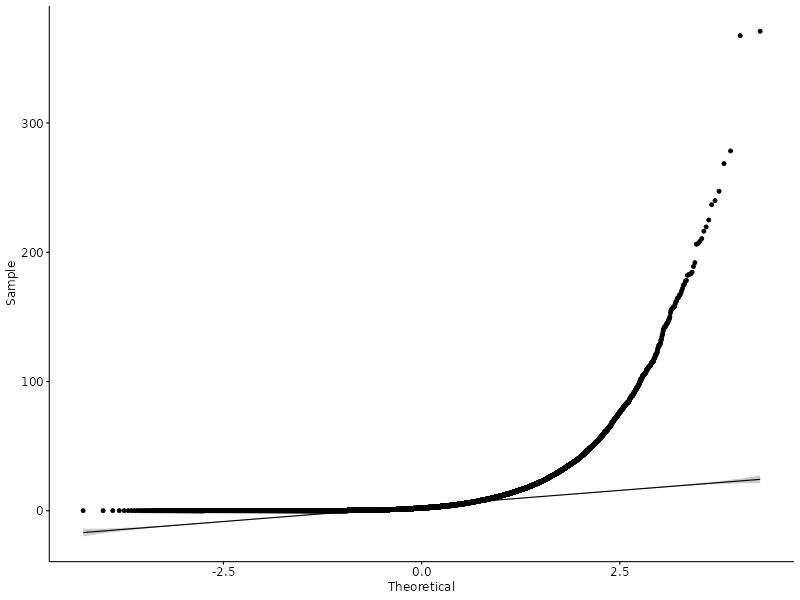

In [ ]:


ggqqplot(seasonal_data, "rainfall", facet_by = "season")

There are outliers, non-normality and so the assumptions of the standard anova are violated

In [32]:
seasonal_data %>% 
  kruskal_test(rainfall ~ season)

# A tibble: 1 × 6
  .y.          n statistic    df        p method        
* <chr>    <int>     <dbl> <int>    <dbl> <chr>         
1 rainfall 51119      230.     3 1.11e-49 Kruskal-Wallis

In [33]:
seasonal_data %>% 
  kruskal_effsize(rainfall ~ season)

# A tibble: 1 × 5
  .y.          n effsize method  magnitude
* <chr>    <int>   <dbl> <chr>   <ord>    
1 rainfall 51119 0.00445 eta2[H] small    

The p-value of the kruskal wallis test shouldnt come as surprising because we have a large sample size of over 140k+ samples, not the effect size matters more, its magnitude being small means seasonality explains only about 0.4% of the variance in rainfall amounts, the signal is real but weak. the solution is we do not need to add the categorical season column because we already added cyclical month features. to prevent multicollinearity since season is just a chunked version of month

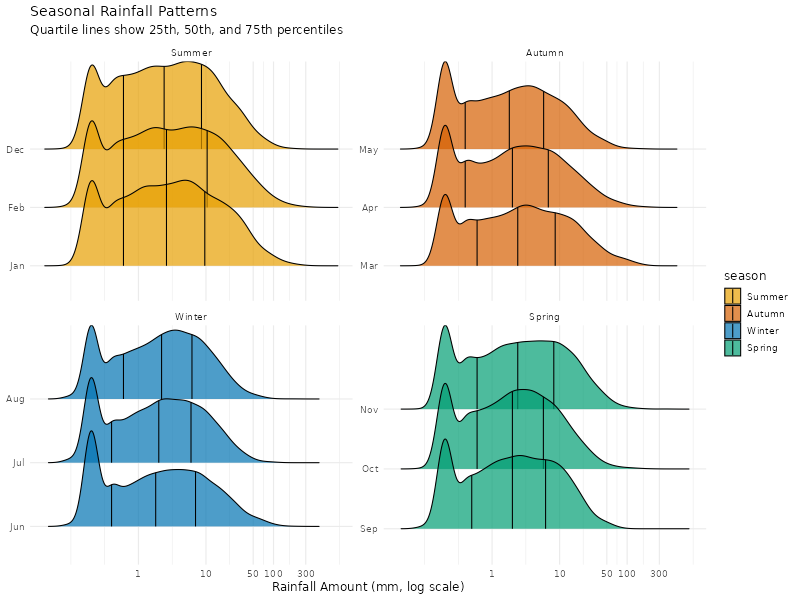

Picking joint bandwidth of 0.129
Picking joint bandwidth of 0.119
Picking joint bandwidth of 0.111
Picking joint bandwidth of 0.116

In [34]:
ggplot(plot_data_seasonal, aes(rainfall, month_label, fill = season)) +
  geom_density_ridges(
    scale = 1.5,
    alpha = 0.7,
    quantile_lines = TRUE,
    quantiles = c(0.25, 0.5, 0.75)
  ) +
  scale_x_log10(
                breaks = c(1, 10, 50, 100, 300),
                labels = label_number(accuracy = 1)) +
  scale_fill_manual(
    values = c("Summer" = "#E69F00", "Autumn" = "#D55E00", 
               "Winter" = "#0072B2", "Spring" = "#009E73")
  ) +
  facet_wrap(~season, scales = "free_y", ncol = 2) +
  labs(
    title = "Seasonal Rainfall Patterns",
    subtitle = "Quartile lines show 25th, 50th, and 75th percentiles",
    x = "Rainfall Amount (mm, log scale)",
    y = NULL
  ) +
  
  theme_minimal(base_size = 12)

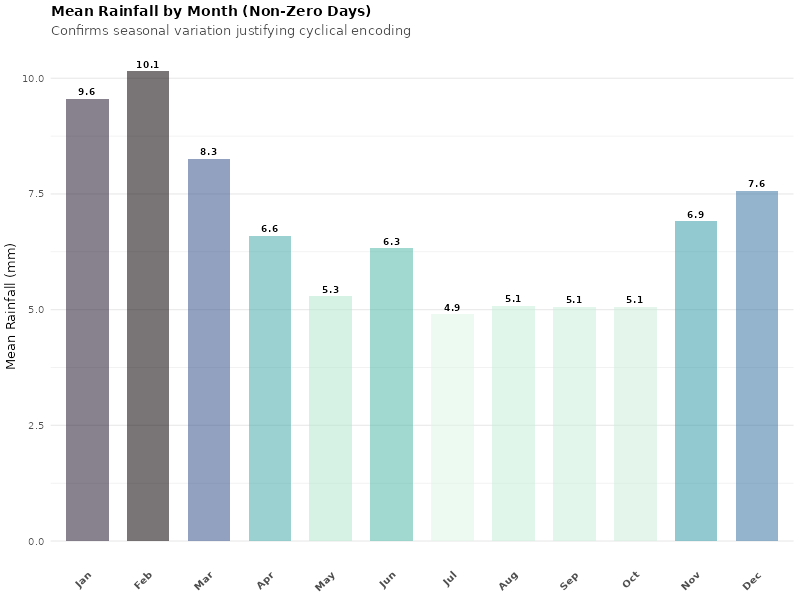

In [35]:
# Is there a sign of seasonal variation in rainfall patterns?
monthly_stats %>% 
  mutate(
    month_label = factor(month.abb[month], levels = month.abb)
  ) %>% 
    ggplot(aes(month_label, mean_rain)) +
    geom_col(aes(fill = mean_rain, alpha = 0.8, width = 0.7)) +
    geom_text(aes(label = round(mean_rain, 1)), 
            vjust = -0.5, size = 3.5, fontface = "bold") +
    scale_fill_viridis_c(option = "mako", direction = -1) +
    labs(
      title = "Mean Rainfall by Month (Non-Zero Days)",
      subtitle = "Confirms seasonal variation justifying cyclical encoding",
      y = "Mean Rainfall (mm)",
      x = NULL
    ) +
    theme_minimal(base_size = 13) +
    theme(
      plot.title = element_text(face = "bold", size = 14),
      plot.subtitle = element_text(color = "grey30", margin = margin(b = 10)),
      legend.position = "none",
      panel.grid.major.x = element_blank(),
      axis.text.x = element_text(angle = 45, hjust = 1, face = "bold")
    )

In [36]:
# Moving Averages Analysis

ma_data <- df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    rainfall_ma3 = rollmean(rainfall, k = 3, fill = NA, align = "right"),
    rainfall_ma7 = rollmean(rainfall, k = 7, fill = NA, align = "right"),
    humidity_ma3 = rollmean(humidity3pm, k = 3, fill = NA, align = "right"),
    humidity_ma7 = rollmean(humidity3pm, k = 7, fill = NA, align = "right"),
  ) %>% 
  ungroup()


In [37]:
p1_data <- ma_data %>% 
  filter(rainfall > 0) %>% 
  select(rainfall, rainfall_ma3, rainfall_ma7) %>% 
  pivot_longer(everything(), names_to = "metric", values_to = "value") %>% 
  filter(!is.na(value)) %>% 
  mutate(
    metric = factor(metric, 
                    levels = c("rainfall", "rainfall_ma3", "rainfall_ma7"),
                    labels = c("Raw Daily", "3-Day MA", "7-Day MA")))



Warning message:
The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
This warning is displayed once per session.
Call ]8;;x-r-run:lifecycle::last_lifecycle_warnings()lifecycle::last_lifecycle_warnings()]8;; to see where this warning was
generated. 


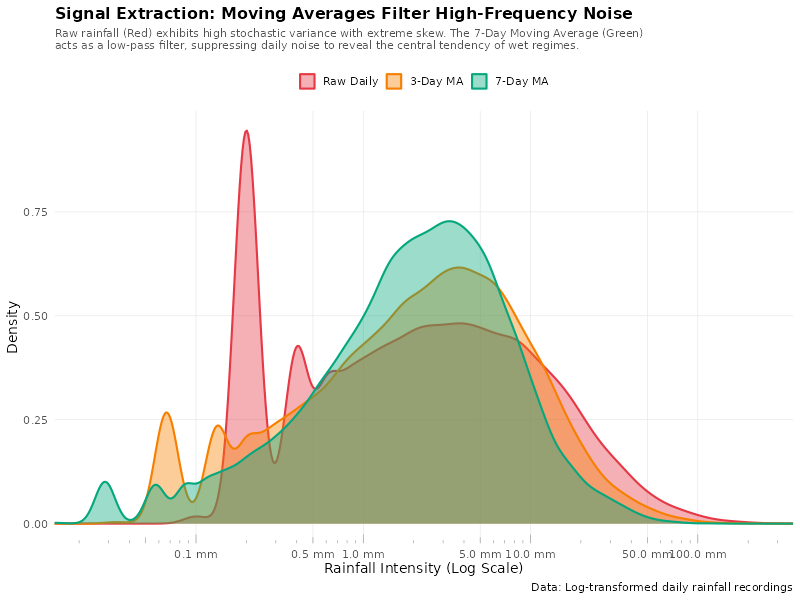

In [38]:
ggplot(p1_data, aes(x = value, fill = metric, color = metric)) +
  geom_density(alpha = 0.4, linewidth = 1) +
  annotation_logticks(sides = "b", color = "grey60", linewidth= 0.3) + 
  scale_x_log10(
    breaks = c(0.1, 0.5, 1, 5, 10, 50, 100), 
    labels = label_number(suffix = " mm"),
    expand = c(0, 0)
  ) +
  
  scale_fill_manual(
    values = c("Raw Daily" = "#E63946", "3-Day MA" = "#F77F00", "7-Day MA" = "#06A77D")
  ) +
  scale_color_manual(
    values = c("Raw Daily" = "#E63946", "3-Day MA" = "#F77F00", "7-Day MA" = "#06A77D")
  ) +
  labs(
    title = "Signal Extraction: Moving Averages Filter High-Frequency Noise",
    subtitle = "Raw rainfall (Red) exhibits high stochastic variance with extreme skew. The 7-Day Moving Average (Green)\nacts as a low-pass filter, suppressing daily noise to reveal the central tendency of wet regimes.",
    x = "Rainfall Intensity (Log Scale)",
    y = "Density",
    caption = "Data: Log-transformed daily rainfall recordings",
    fill = NULL,
    color = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_line(color = "grey90", size = 0.3),
    panel.grid.major.y = element_line(color = "grey90", size = 0.3),
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(color = "grey30", size = 11, margin = margin(b = 15)),
    axis.text.x = element_text(margin = margin(t = 5))
  )

In [39]:
# Variance Reduction Quantification

variance_data <- ma_data %>% 
  filter(rainfall > 0) %>% 
  summarise(
    Raw = sd(rainfall, na.rm = TRUE),
    `3-Day MA` = sd(rainfall_ma3, na.rm = TRUE),
    `7-Day MA` = sd(rainfall_ma7, na.rm = TRUE)
  ) %>% 
  pivot_longer(everything(), names_to = "metric", values_to = "sd") %>% 
  mutate(
    metric = factor(metric, levels = c("Raw", "3-Day MA", "7-Day MA")),
    variance_reduction = (sd[1] - sd) / sd[1] * 100
  )

variance_data

# A tibble: 3 × 3
  metric      sd variance_reduction
  <fct>    <dbl>              <dbl>
1 Raw      13.1                 0  
2 3-Day MA  8.55               34.9
3 7-Day MA  5.81               55.7

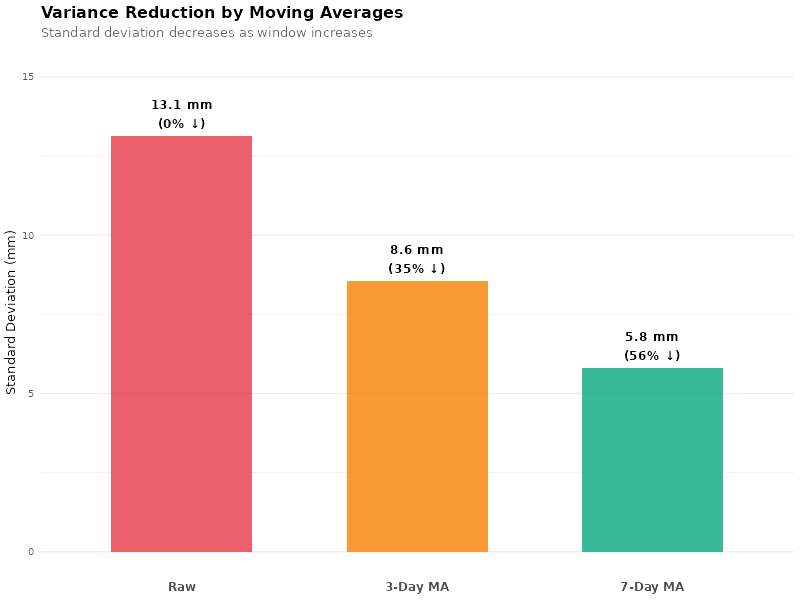

In [40]:
ggplot(variance_data, aes(metric, sd, fill = metric)) +
  geom_col(alpha = 0.8, width = 0.6) +
  geom_text(aes(label = sprintf("%.1f mm\n(%.0f%% ↓)", sd, variance_reduction)),
            vjust = -0.3, fontface = "bold", size = 4.5) +
  scale_fill_manual(
    values = c("Raw" = "#E63946", 
               "3-Day MA" = "#F77F00", 
               "7-Day MA" = "#06A77D")
  ) +
  labs(
    title = "Variance Reduction by Moving Averages",
    subtitle = "Standard deviation decreases as window increases",
    y = "Standard Deviation (mm)",
    x = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(color = "grey40", margin = margin(b = 10)),
    legend.position = "none",
    panel.grid.major.x = element_blank(),
    axis.text.x = element_text(face = "bold", size = 12)) +
  ylim(0, max(variance_data$sd) * 1.15)

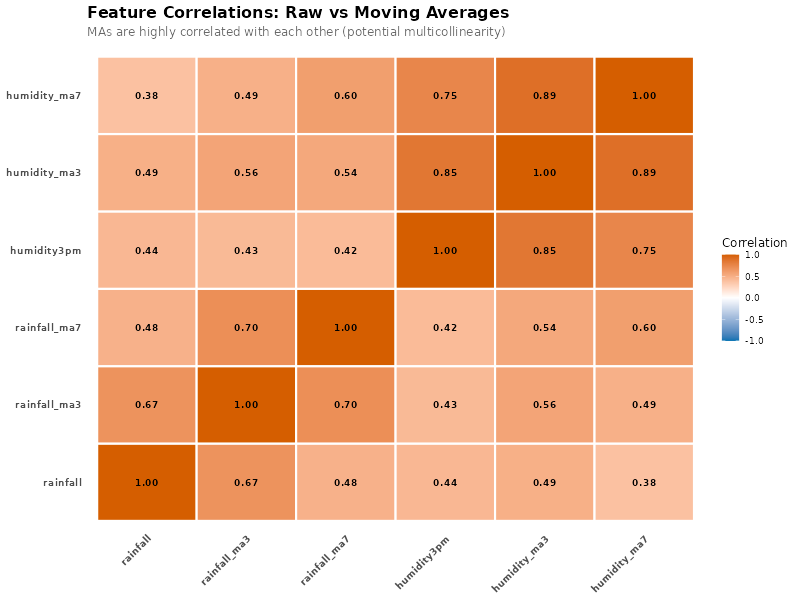

In [41]:
# Correlation heatmap

cor_data <- ma_data %>% 
  select(rainfall, rainfall_ma3, rainfall_ma7, humidity3pm, humidity_ma3, humidity_ma7) %>% 
  cor(use = "complete.obs", method = "spearman") %>% 
  as.data.frame() %>% 
  rownames_to_column("var1") %>% 
  pivot_longer(-var1, names_to = "var2", values_to = "correlation") %>% 
  mutate(
    var1 = factor(var1, levels = c("rainfall", "rainfall_ma3", "rainfall_ma7",
                                    "humidity3pm", "humidity_ma3", "humidity_ma7")),
    var2 = factor(var2, levels = c("rainfall", "rainfall_ma3", "rainfall_ma7",
                                    "humidity3pm", "humidity_ma3", "humidity_ma7"))
  )  

ggplot(cor_data, aes(var2, var1, fill = correlation)) +
  geom_tile(color = "white", linewidth = 1) +
  geom_text(aes(label = sprintf("%.2f", correlation)),
            fontface = "bold", size = 3.5) +
  scale_fill_gradient2(
    low = "#0072B2", 
    mid = "white", 
    high = "#D55E00",
    midpoint = 0,
    limits = c(-1, 1),
    name = "Correlation"
  ) +
  labs(
    title = "Feature Correlations: Raw vs Moving Averages",
    subtitle = "MAs are highly correlated with each other (potential multicollinearity)",
    x = NULL, 
    y = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(color = "grey40", margin = margin(b = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
    axis.text.y = element_text(face = "bold"),
    panel.grid = element_blank())
  

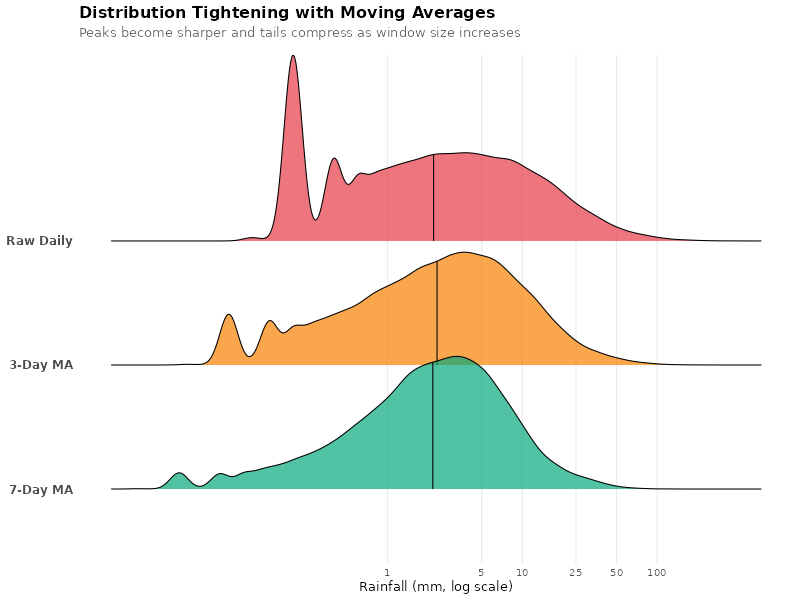

Picking joint bandwidth of 0.0669

In [42]:
ridge_data <- ma_data %>% 
  filter(rainfall > 0) %>% 
  select(rainfall, rainfall_ma3, rainfall_ma7) %>% 
  pivot_longer(everything(), names_to = "metric", values_to = "value") %>% 
  filter(!is.na(value)) %>% 
  mutate(
    metric = factor(metric,
                    levels = c("rainfall_ma7", "rainfall_ma3", "rainfall"),
                    labels = c("7-Day MA", "3-Day MA", "Raw Daily"))
  )

ggplot(ridge_data, aes(value, metric, fill = metric)) +
  geom_density_ridges(
    alpha = 0.7,
    scale = 1.5,
    quantile_lines = TRUE,
    quantiles = 2
  ) +
  scale_x_log10(breaks = c(1, 5, 10, 25, 50, 100),
    labels = c("1", "5", "10", "25", "50", "100")) +
  scale_fill_manual(values = c("Raw Daily" = "#E63946", 
               "3-Day MA" = "#F77F00", 
               "7-Day MA" = "#06A77D")) +
  labs(
    title = "Distribution Tightening with Moving Averages",
    subtitle = "Peaks become sharper and tails compress as window size increases",
    x = "Rainfall (mm, log scale)",
    y = NULL
  ) +
  
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(color = "grey40", margin = margin(b = 15)),
    legend.position = "none",
    axis.text.y = element_text(face = "bold", size = 12),
    panel.grid.minor = element_blank(),
    panel.grid.major.y = element_blank()
  )

# Engineer some features

In [43]:
compass_lookup <- c(
  "N"=0, "NNE"=22.5, "NE"=45, "ENE"=67.5,
  "E"=90, "ESE"=112.5, "SE"=135, "SSE"=157.5,
  "S"=180, "SSW"=202.5, "SW"=225, "WSW"=247.5,
  "W"=270, "WNW"=292.5, "NW"=315, "NNW"=337.5
)

In [44]:
df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  # We had a potential data leakage where we used todays rainfall, humidity to predict todays rain,
  # I had to add the lags below so it works fine
  mutate(rainfall_ma7 = lag(rollmean(rainfall, k = 7, fill = NA, align = "right"), n = 1),
        humidity_ma7 = lag(rollmean(humidity3pm, k = 7, fill = NA, align = "right"), 1),
        rain_event_id = cumsum(lag(rainfall, 1) > 0),
        days_since_rain = row_number() - match(rain_event_id, rain_event_id),
        rain_yesterday = lag(rain_today, n = 1)) %>% 
  ungroup() %>% 
  filter(!is.na(rain_yesterday), !is.na(rainfall_ma7)) %>% 
  select(-rain_event_id) %>% 
  mutate(
        day_of_year = yday(date),
        pressure_change = pressure3pm - pressure9am,
        sun_humid_interaction = as.numeric(sunshine * humidity3pm),
        dewpoint_9am = temp9am - ((100 - humidity9am) / 5),
        dewpoint_3pm = temp3pm - ((100 - humidity3pm) / 5),
        dewpoint_change = dewpoint_3pm - dewpoint_9am,
        moisture_index = humidity3pm * (1-sunshine / 15),
        instability_index = (1020 - pressure3pm) * humidity3pm/100,
        cloud_development = pmax(0, cloud3pm - cloud9am),
        day_sin = sin(2 * pi * day_of_year / 365),
        day_cos = cos(2 * pi * day_of_year / 365),
        gust_rad = compass_lookup[wind_gust_dir] * pi / 180,
        gust_V_NS = wind_gust_speed * cos(gust_rad),
        gust_U_EW = wind_gust_speed * sin(gust_rad),
        wind9am_rad = compass_lookup[wind_dir9am] * pi / 180,
        wind9am_V_NS = wind_speed9am * cos(wind9am_rad),
        wind9am_U_EW = wind_speed9am * sin(wind9am_rad)
        ) %>% 
  relocate(rain_today, date, location) %>% 
  relocate(rain_yesterday, days_since_rain, .after = location) %>%
  relocate(ends_with("_ma7"), .after = days_since_rain) %>% 
  relocate(day_sin, day_cos, .after = date) -> df_final

# Trim the columns


In [45]:
df_test <- df_final %>% 
  select(-location)

In [46]:
vif_check <- lm(rainfall ~ ., data = df_test)
check_collinearity(vif_check)

Model matrix is rank deficient. VIFs may not be sensible.


# Check for Multicollinearity

Low Correlation

                 Term  VIF           VIF 95% CI adj. VIF Tolerance
           rain_today 1.46 [    1.45,     1.47]     1.21      0.68
       rain_yesterday 1.24 [    1.23,     1.25]     1.11      0.80
         rainfall_ma7 1.35 [    1.34,     1.36]     1.16      0.74
         humidity_ma7 2.62 [    2.60,     2.64]     1.62      0.38
          evaporation 2.17 [    2.16,     2.19]     1.47      0.46
      wind_gust_speed 2.68 [    2.66,     2.70]     1.64      0.37
        wind_speed9am 1.96 [    1.95,     1.98]     1.40      0.51
        wind_speed3pm 2.06 [    2.05,     2.08]     1.44      0.48
          humidity9am 4.26 [    4.22,     4.30]     2.06      0.23
             cloud9am 4.60 [    4.56,     4.64]     2.14      0.22
             cloud3pm 3.91 [    3.87,     3.94]     1.98      0.26
                  day 1.02 [    1.01,     1.02]     1.00      0.98
 sunshine_imp_flagged 3.30 [    3.27,     3.33]     1.82      0.30
     evap_imp_

In [47]:
df_final %>% 
  select(-c(month, day, day_of_year, date)) %>% 
  select(-c(temp9am, temp3pm, min_temp, max_temp)) %>% 
  select(-c(pressure3pm, pressure9am)) %>% 
  select(-c(cloud3pm, cloud9am)) %>% 
  select(-ends_with("_imp_flagged")) %>% 
  select(-location) %>%   
  select(-c(dewpoint_3pm, wind_dir3pm)) %>%
  select(-c(wind_gust_dir, wind_gust_speed, wind_speed9am, wind_dir9am, wind9am_rad, gust_rad)) %>% 
  ungroup() -> df_test

In [48]:

vif_check <- lm(rainfall ~ ., data = df_test)
check_collinearity(vif_check)

Model matrix is rank deficient. VIFs may not be sensible.


# Check for Multicollinearity

Low Correlation

              Term  VIF     VIF 95% CI adj. VIF Tolerance Tolerance 95% CI
        rain_today 1.40 [ 1.39,  1.41]     1.18      0.71     [0.71, 0.72]
           day_sin 1.20 [ 1.20,  1.21]     1.10      0.83     [0.83, 0.84]
           day_cos 2.26 [ 2.24,  2.28]     1.50      0.44     [0.44, 0.45]
    rain_yesterday 1.23 [ 1.23,  1.24]     1.11      0.81     [0.81, 0.82]
   days_since_rain 1.01 [ 1.01,  1.02]     1.01      0.99     [0.98, 0.99]
      rainfall_ma7 1.34 [ 1.33,  1.35]     1.16      0.75     [0.74, 0.75]
      humidity_ma7 2.42 [ 2.40,  2.44]     1.56      0.41     [0.41, 0.42]
       evaporation 2.02 [ 2.01,  2.04]     1.42      0.49     [0.49, 0.50]
     wind_speed3pm 1.18 [ 1.18,  1.19]     1.09      0.84     [0.84, 0.85]
       humidity9am 3.11 [ 3.09,  3.14]     1.76      0.32     [0.32, 0.32]
   pressure_change 1.71 [ 1.70,  1.72]     1.31      0.58     [0.58, 0.59]
      dewpoint_9am 2.23 [ 2.21,  2.24]     1.49     

"High VIF on interaction terms and their components is expected and not problematic for inference, provided both main effects are included in the model."
— Aiken & West (1991), Multiple Regression"

This explains why the sunshine, humidity and their interaction should be taken with a pinch of salt for now

In [ ]:
 
model_matrix <- model.matrix(rainfall ~ ., data = df_test)

linear_combos <- findLinearCombos(model_matrix)
print(linear_combos)


Loading required package: lattice

Attaching package: ‘caret’

The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity

The following object is masked from ‘package:rsample’:

    calibration

The following object is masked from ‘package:purrr’:

    lift

$linearCombos
$linearCombos[[1]]
[1] 18 13 15


$remove
[1] 18



In [50]:
# See which columns these are
print(colnames(model_matrix)[c(18, 13, 15)])

[1] "moisture_index"        "humidity3pm"           "sun_humid_interaction"


In [51]:
# Column 18 is the one to remove
print(colnames(model_matrix)[18])
# So moisture index can be written as a linear combination of the humidity3pm and the sun_humid_interaction



[1] "moisture_index"


In [52]:
df_final %>% 
  select(-c(month, day, day_of_year, date)) %>% 
  select(-c(temp9am, temp3pm, min_temp, max_temp)) %>% 
  select(-c(pressure3pm, pressure9am)) %>% 
  select(-c(cloud3pm, cloud9am)) %>% 
  select(-ends_with("_imp_flagged")) %>% 
  select(-location) %>%   
  select(-c(dewpoint_3pm, wind_dir3pm)) %>%
  select(-moisture_index) %>% 
  select(-rain_today) %>% 
  select(-c(wind_gust_dir, wind_gust_speed, wind_speed9am, wind_dir9am, wind9am_rad, gust_rad)) %>% 
  select(-wind_speed3pm) %>% 
  ungroup() -> df_test



In [53]:

vif_check <- lm(rainfall ~ ., data = df_test)
check_collinearity(vif_check)

# Check for Multicollinearity

Low Correlation

              Term  VIF     VIF 95% CI adj. VIF Tolerance Tolerance 95% CI
           day_sin 1.20 [ 1.19,  1.20]     1.09      0.84     [0.83, 0.84]
           day_cos 2.25 [ 2.23,  2.27]     1.50      0.44     [0.44, 0.45]
    rain_yesterday 1.19 [ 1.18,  1.20]     1.09      0.84     [0.84, 0.85]
   days_since_rain 1.01 [ 1.01,  1.02]     1.00      0.99     [0.98, 0.99]
      rainfall_ma7 1.33 [ 1.33,  1.34]     1.15      0.75     [0.74, 0.75]
      humidity_ma7 2.41 [ 2.39,  2.43]     1.55      0.41     [0.41, 0.42]
       evaporation 2.02 [ 2.00,  2.03]     1.42      0.50     [0.49, 0.50]
       humidity9am 2.91 [ 2.88,  2.93]     1.70      0.34     [0.34, 0.35]
   pressure_change 1.66 [ 1.65,  1.68]     1.29      0.60     [0.60, 0.61]
      dewpoint_9am 2.22 [ 2.20,  2.24]     1.49      0.45     [0.45, 0.45]
   dewpoint_change 2.13 [ 2.11,  2.15]     1.46      0.47     [0.47, 0.47]
 instability_index 1.49 [ 1.48,  1.50]     1.22     

In [54]:

df_scaled <- df_test %>%
  mutate(across(
    .cols = where(is.numeric) & !c("rainfall"), 
    .fns = scale
  ))


In [55]:
m0_null <- glmmTMB(
  rainfall ~ 1, ziformula = ~ 1, data = df_scaled, family = ziGamma(link = "log")
)

summary(m0_null)

 Family: Gamma  ( log )
Formula:          rainfall ~ 1
Zero inflation:            ~1
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 461669.7  461699.3 -230831.8  461663.7    141853 


Dispersion estimate for Gamma family (sigma^2): 1.88 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 1.882520   0.006072     310   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 0.576891   0.005533   104.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [56]:
# For rain to occur, we must have moisture
m1_moisture <- update(m0_null, . ~ . + humidity3pm + dewpoint_9am + dewpoint_change + pressure_change, 
                      ziformula = ~ humidity3pm + dewpoint_9am)
summary(m1_moisture)

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change
Zero inflation:            ~humidity3pm + dewpoint_9am
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 423812.5  423901.2 -211897.2  423794.5    141847 


Dispersion estimate for Gamma family (sigma^2): 1.64 

Conditional model:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.320661   0.007653  172.57   <2e-16 ***
humidity3pm      0.391001   0.006527   59.90   <2e-16 ***
dewpoint_9am     0.363467   0.005584   65.09   <2e-16 ***
dewpoint_change -0.097775   0.006941  -14.09   <2e-16 ***
pressure_change  0.205440   0.005342   38.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.7130514  0.0063468  112.35   <2e-16 ***
humidity3pm  -1.0602930  0.0074015 -143.25   <2e-16 ***
dewpoint_9am -0.0003217  0.

In [57]:
m2_temporal <- update(m1_moisture, . ~ . + day_cos + day_sin,
                      ziformula = ~ humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + pressure_change)
summary(m2_temporal)

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +  
    day_cos + day_sin
Zero inflation:            
~humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + 
    pressure_change
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 407932.3  408070.4 -203952.2  407904.3    141842 


Dispersion estimate for Gamma family (sigma^2): 1.64 

Conditional model:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.309688   0.007712  169.82  < 2e-16 ***
humidity3pm      0.412117   0.007028   58.64  < 2e-16 ***
dewpoint_9am     0.346990   0.007685   45.15  < 2e-16 ***
dewpoint_change -0.113393   0.007554  -15.01  < 2e-16 ***
pressure_change  0.199438   0.005500   36.26  < 2e-16 ***
day_cos          0.050675   0.007473    6.78 1.19e-11 ***
day_sin         -0.039908   0.006365   -6.27 3.60e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation

In [58]:
m3_history <- update(m2_temporal, . ~ . + rainfall_ma7 + days_since_rain + humidity_ma7 +rain_yesterday,
                      ziformula = ~ humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + pressure_change)
summary(m3_history) 

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +  
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 +  
    rain_yesterday
Zero inflation:            
~humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + 
    pressure_change
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 406212.8  406390.4 -203088.4  406176.8    141838 


Dispersion estimate for Gamma family (sigma^2):  1.6 

Conditional model:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.158659   0.008771  132.11  < 2e-16 ***
humidity3pm        0.408640   0.007653   53.40  < 2e-16 ***
dewpoint_9am       0.300397   0.007765   38.68  < 2e-16 ***
dewpoint_change   -0.134419   0.007445  -18.06  < 2e-16 ***
pressure_change    0.191497   0.005423   35.31  < 2e-16 ***
day_cos            0.046819   0.007461    6.28 3.49e-10 ***
day_sin           -0.046846   0.006240   -7.51 6.06e-14

In [59]:
m4_energy <- update(m3_history, . ~ . + sunshine + evaporation + instability_index + sun_humid_interaction + cloud_development,
                      ziformula = ~ humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + pressure_change)
summary(m4_energy) 

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +  
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 +  
    rain_yesterday + sunshine + evaporation + instability_index +  
    sun_humid_interaction + cloud_development
Zero inflation:            
~humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + 
    pressure_change
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 403965.3  404192.1 -201959.6  403919.3    141833 


Dispersion estimate for Gamma family (sigma^2): 1.55 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.131226   0.008857  127.72  < 2e-16 ***
humidity3pm            0.448634   0.018327   24.48  < 2e-16 ***
dewpoint_9am           0.257764   0.007949   32.43  < 2e-16 ***
dewpoint_change       -0.140400   0.007680  -18.28  < 2e-16 ***
pressure_change        0.225854   0.005750   39.28  < 2e-16 

In [60]:
df_test %>% 
  names()

 [1] "day_sin"               "day_cos"               "rain_yesterday"       
 [4] "days_since_rain"       "rainfall_ma7"          "humidity_ma7"         
 [7] "rainfall"              "evaporation"           "sunshine"             
[10] "humidity9am"           "humidity3pm"           "pressure_change"      
[13] "sun_humid_interaction" "dewpoint_9am"          "dewpoint_change"      
[16] "instability_index"     "cloud_development"     "gust_V_NS"            
[19] "gust_U_EW"             "wind9am_V_NS"          "wind9am_U_EW"         

In [61]:
m5_wind <- update(m4_energy, . ~ . + gust_U_EW + gust_V_NS + wind9am_V_NS + wind9am_U_EW,
                      ziformula = ~ humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + pressure_change)
summary(m5_wind) # We might not even need the entire 16 point compass, the 4 cardinal points may just be enough instead of burning through 15 degrees of freedom

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +  
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 +  
    rain_yesterday + sunshine + evaporation + instability_index +  
    sun_humid_interaction + cloud_development + gust_U_EW + gust_V_NS +  
    wind9am_V_NS + wind9am_U_EW
Zero inflation:            
~humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + 
    pressure_change
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 403104.7  403371.0 -201525.3  403050.7    141829 


Dispersion estimate for Gamma family (sigma^2): 1.53 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.103247   0.008860  124.53  < 2e-16 ***
humidity3pm            0.436327   0.018256   23.90  < 2e-16 ***
dewpoint_9am           0.273879   0.008215   33.34  < 2e-16 ***
dewpoint_change       -0.142009   0.007623  -18.63  < 2e-16 ***


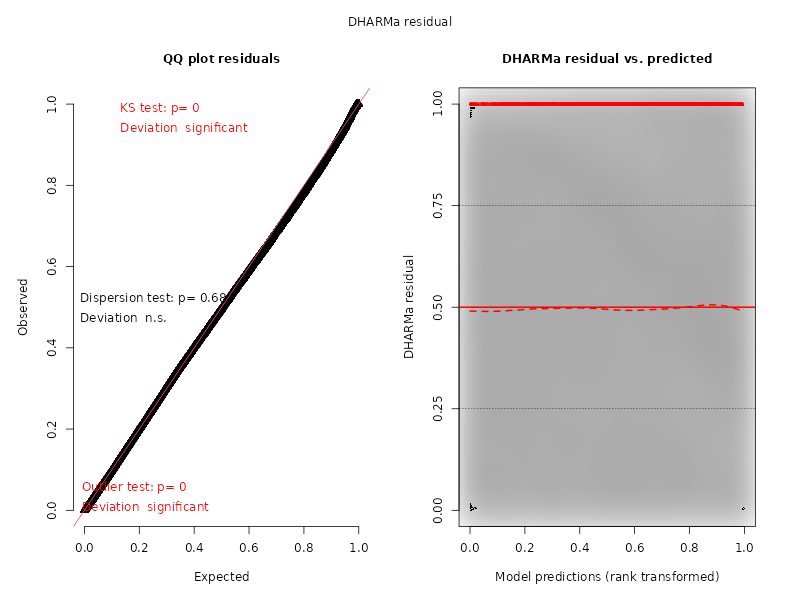

In [ ]:

res <- simulateResiduals(m5_wind)
plot(res)

Good results so far, but be wary of autocorrelation introduced by lags

In [63]:
AIC(m0_null, m1_moisture, m2_temporal, m5_wind, m4_energy, m3_history)

            df      AIC
m0_null      3 461669.7
m1_moisture  9 423812.5
m2_temporal 14 407932.3
m5_wind     27 403104.7
m4_energy   23 403965.3
m3_history  18 406212.8

In [64]:
# Identify which row numbers survived into the model
rows_used <- as.numeric(rownames(m5_wind$frame))
# pull back Date and Location matching the row number of the model order
df_diag <- df_final[rows_used, ] %>% 
  mutate(
    dharma_resid = residuals(res)
  )


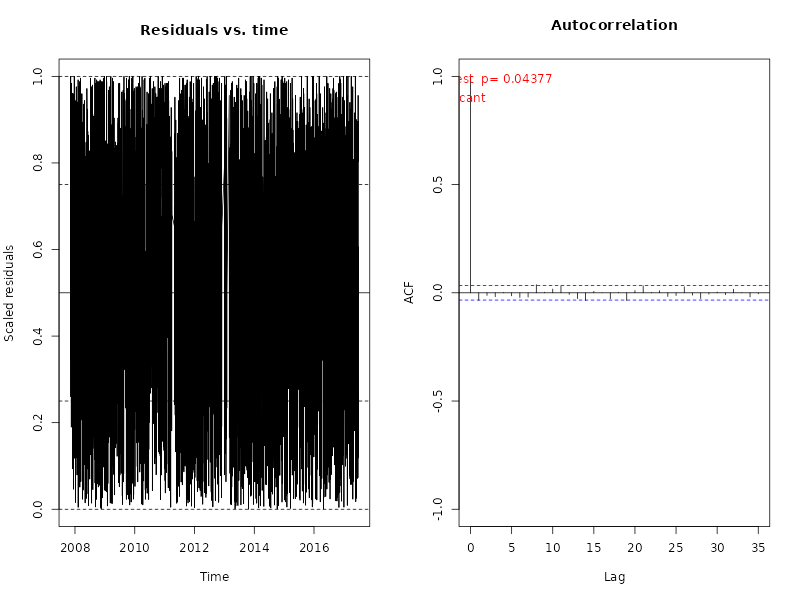


	Durbin-Watson test

data:  simulationOutput$scaledResiduals ~ 1
DW = 2.069, p-value = 0.04377
alternative hypothesis: true autocorrelation is not 0



In [74]:
Canberra_data <- df_diag %>% 
  filter(location == "Canberra") %>% 
  arrange(date)

dw_result <- testTemporalAutocorrelation(simulationOutput = Canberra_data$dharma_resid, 
                            time = Canberra_data$date)

print(dw_result)


In [ ]:


df_final$pred_rainfall <- predict(m5_wind, type = "response")
# Get the global RMSE
global_rmse <- sqrt(mean((df_final$rainfall - df_final$pred_rainfall)^2))

# get the global MAE
global_mae <- mean(abs(df_final$rainfall - df_final$pred_rainfall))

print(paste("Global RMSE:", round(global_rmse, 3), "mm"))
print(paste("Global MAE:", round(global_mae, 3), "mm"))


Attaching package: ‘Metrics’

The following objects are masked from ‘package:caret’:

    precision, recall

The following objects are masked from ‘package:performance’:

    mae, mse, rmse

The following objects are masked from ‘package:yardstick’:

    accuracy, mae, mape, mase, precision, recall, rmse, smape

[1] "Global RMSE: 7.8 mm"
[1] "Global MAE: 2.8 mm"


# Compare with the lazy guess

In [ ]:
# Calculate the Standard Deviation of the actual rainfall
sd_rain <- sd(df_final$rainfall)
print(paste("Standard Deviation:", round(sd_rain, 2)))

if(7.8 < sd_rain) {
  print("SUCCESS: The model is better than just guessing the average.")
} else {
  print("WARNING: The model is struggling to beat random noise.")
}

[1] "Standard Deviation: 8.48"
[1] "SUCCESS: Your model is better than just guessing the average."


In [68]:
# Generate and visualize predictions

In [69]:
# use tweedie glmmTMB instead of the hurdle zigamma


In [70]:
# Use GAM with tweedie to capture non linear relationships

In [71]:
# Statistical model comparison (AIC x BIC) 

In [72]:
# Diagnose the GAM using Dharma

In [73]:
# Bayesian Inference?